In [1]:
import torch
import yolo
from PIL import Image
from torchvision import transforms
import torchvision

import numpy as np


ckpt_path = r"Varmedian\varmod-s-210.pth"
N = 4
s = 2.0


# COCO dataset, 80 classes
classes = (
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush")

model_sizes = {"small": (0.33, 0.5), "medium": (0.67, 0.75), "large": (1, 1), "extreme": (1.33, 1.25)}

model = yolo.YOLOv5(80,model_size=model_sizes['small'], img_sizes=620, score_thresh=0.3, nms_thresh=0.3, N=N, s=s)
model.eval()

checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [3]:
def uncertanity_non_max_sup(boxes, scores, threshold):
    order = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    keep = []
    same_detect = {}
    while order:
        i = order.pop(0)
        same_detect[i] = []
        keep.append(i)
        k = 0
        while k < len(order):
            j = order[k]
            
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            if float(iou) > threshold:
                same_detect[i].append(j)
                order.remove(j)
            else:
                k += 1
    return keep, same_detect


In [4]:
def non_max_sup_mean(results, N=4, iou_thres=0.45):
    boxes, labels, scores, sigmas = torch.empty(0), torch.empty(0,dtype=int), torch.empty(0), torch.empty(0)

    if len(results[0]['boxes']) == 1:
        return results[0]

    for i in range(N):
        boxes = torch.cat((boxes,results[i]['boxes']))
        labels = torch.cat((labels,results[i]['labels']))
        scores = torch.cat((scores,results[i]['scores']))
        sigmas = torch.cat((sigmas,results[i]['sigmas']))

    nms_ids, same_detect = uncertanity_non_max_sup(boxes, scores, iou_thres)

    #Agregar variables para el promedio y varianza

    boxes_fin, labels_fin, scores_fin = torch.empty((1,4)), torch.empty(0,dtype=int), torch.empty(0)
    sigmas_fin, sigmas_epis = torch.empty(0), torch.empty(0)
    for i in nms_ids:

        if len(same_detect[i]) > 0:
            #Promediando detecciones iguales
            detection_mean = torch.zeros_like(boxes[i])
            for detection in same_detect[i]:
                detection_mean +=  boxes[detection]
            detection_mean = detection_mean / len(same_detect[i])

            #Desviacion estandar epistemica
            sd_mean = torch.zeros_like(boxes[i])
            for detection in same_detect[i]:
                sum_tmp = torch.abs(boxes[detection] - detection_mean)
                sd_mean += sum_tmp * sum_tmp
            sd_mean = torch.sqrt(sd_mean / (len(same_detect[i])-1))
        else:
            detection_mean = boxes[i]
            sd_mean = torch.zeros_like(boxes[i])

        boxes_fin = torch.cat((boxes_fin, detection_mean.expand(1,4)))
        labels_fin = torch.cat((labels_fin, labels[i].expand(1)))
        scores_fin = torch.cat((scores_fin, scores[i].expand(1)))
        sigmas_fin = torch.cat((sigmas_fin, sigmas[i].expand(1,4)))
        sigmas_epis = torch.cat((sigmas_epis, sd_mean.expand(1,4)))
    boxes_fin = boxes_fin[1:]

    results_nms = {'boxes':boxes_fin, 'labels':labels_fin, 'scores':scores_fin, 'sigmas':sigmas_fin, 'espis_var':sigmas_epis}

    return results_nms, same_detect


In [ ]:
img = Image.open(r'images\000.jpg').convert("RGB")
img = transforms.ToTensor()(img)

model.head.merge = False

images = [img]*N
results, losses = model(images)

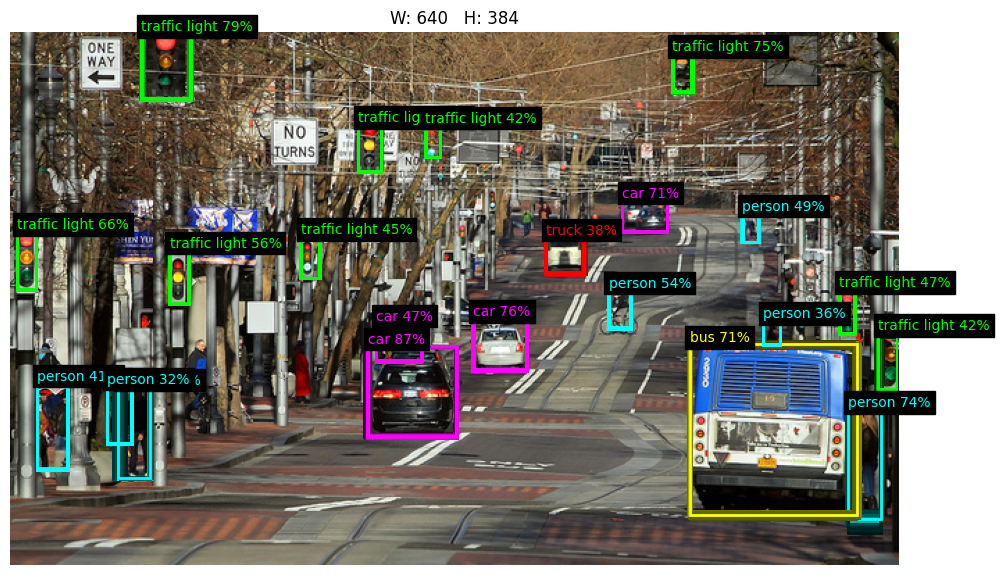

In [5]:
results_1, same_det = non_max_sup_mean(results, N=N)
yolo.show(images[0], [results_1], classes, save="r000.jpg", samples=100)

torch.Size([3, 375, 500])


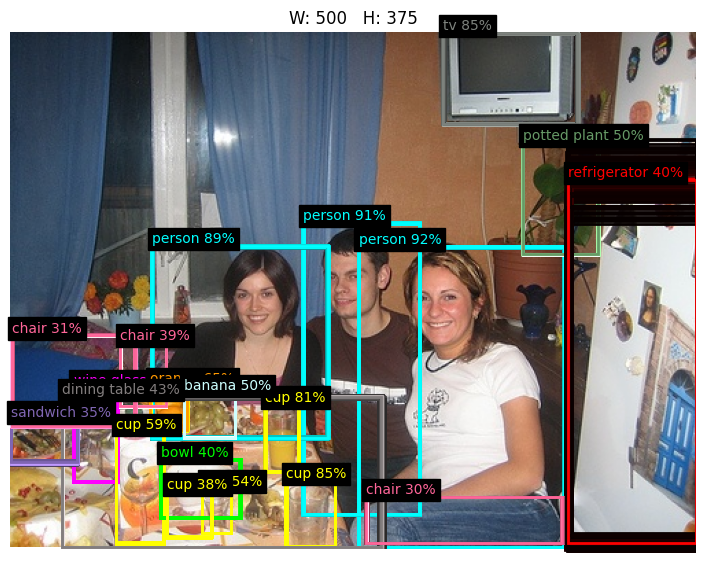

torch.Size([3, 500, 333])


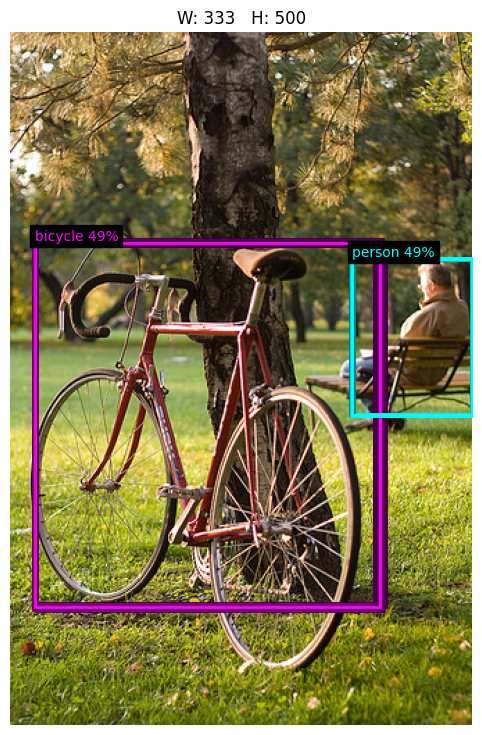

torch.Size([3, 375, 500])


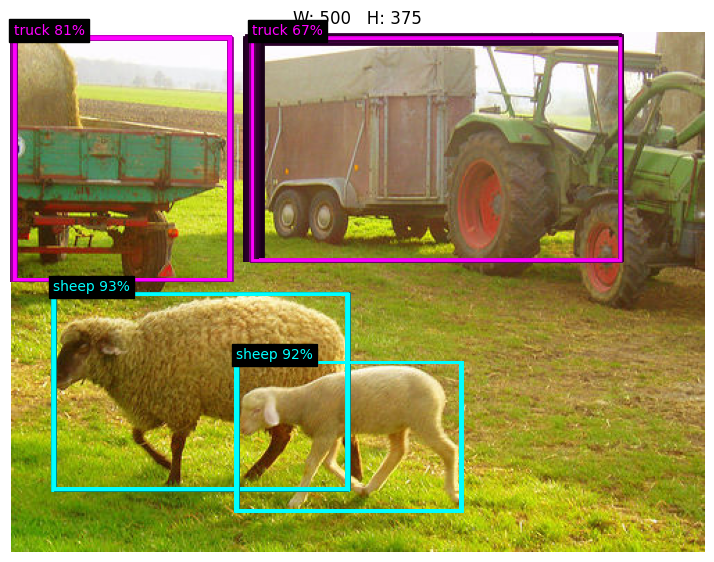

torch.Size([3, 297, 500])


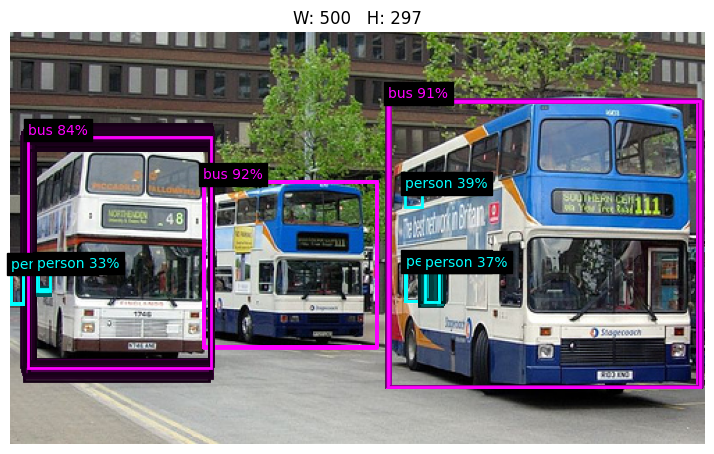

torch.Size([3, 375, 500])


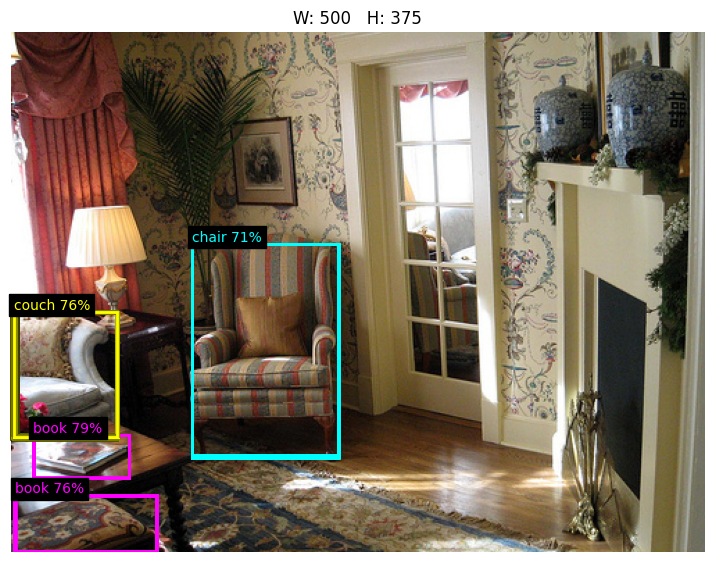

In [9]:
import os 
path = 'data\samples+voc'
files = os.listdir('data\samples+voc')
for file in files:
    img = Image.open(os.path.join(path, file)).convert("RGB")
    img = transforms.ToTensor()(img)
    print(img.shape)
    model.head.merge = False

    images = [img]*N
    results, losses = model(images)
    results = non_max_sup_mean(results, N=N)
    yolo.show(images[0], results, classes, save="r000.jpg", samples=100)

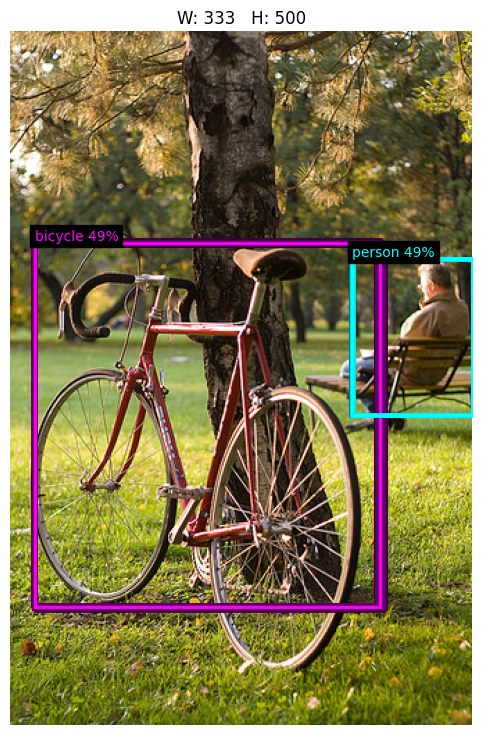

In [18]:
img = Image.open(r'data\samples+voc/2009_000149.jpg').convert("RGB")
img = transforms.ToTensor()(img)

model.head.merge = False

images = [img]*N
results, losses = model(images)

results_1, same_det = non_max_sup_mean(results, N=N)
yolo.show(images[0], [results_1], classes, save="r000.jpg", samples=100)

In [19]:
results[0]

{'boxes': tensor([[235.0341, 160.3917, 331.9661, 285.1356],
         [ 17.7095, 151.5473, 264.1504, 415.3934]], grad_fn=<DivBackward0>),
 'labels': tensor([0, 1]),
 'scores': tensor([0.4861, 0.4761], grad_fn=<IndexBackward0>),
 'sigmas': tensor([[-2.0148, -2.3398, -2.0118, -2.2973],
         [-0.9671, -1.2767, -0.9783, -1.3275]], grad_fn=<IndexBackward0>)}

In [20]:
losses

{}

# below is to test COCO val2017 dataset

In [64]:
import os

use_cuda = False
dataset = "coco" # currently only support VOC and COCO datasets
file_root = "data/coco2017/val2017"
ann_file = "data/coco2017/annotations/instances_val2017.json"
output_dir = "yolov5s_val2017"

# create output directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# choose device and show GPU information
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
cuda = device.type == "cuda"
if cuda: yolo.get_gpu_prop(show=True)
print("\ndevice: {}".format(device))

ds = yolo.datasets(dataset, file_root, ann_file, train=True)
dl = torch.utils.data.DataLoader(ds, shuffle=True, collate_fn=yolo.collate_wrapper, pin_memory=cuda)
# DataPrefetcher behaves like PyTorch's DataLoader, but it outputs CUDA tensors
d = yolo.DataPrefetcher(dl) if cuda else dl

model.to(device)

if ckpt_path:
    checkpoint = torch.load(ckpt_path, map_location=device)
    if "ema" in checkpoint:
        model.load_state_dict(checkpoint["ema"][0])
        print(checkpoint["eval_info"])
    else:
        model.load_state_dict(checkpoint)
    del checkpoint
    if cuda: torch.cuda.empty_cache()
    
for p in model.parameters():
    p.requires_grad_(False)


device: cpu
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Averag